In [4]:
##Import library##
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


***Data Processing***

In [0]:
##Load data##
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [7]:
##Data directories##
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

##Glancing at the data##
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [9]:
##Setting up##
IMG_HEIGHT = 64
IMG_WIDTH = 64

##Data preparation##
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=total_train,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=total_val,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

##Format data for scikit format##
def prep_data(images):
  x,y = next(images)
  m = len(y)
  n_x = IMG_HEIGHT*IMG_WIDTH*3
  
  ##Need to reshape picture into this array format##
  X = np.ndarray((n_x,m), dtype=np.float)
  for i in range(m):
    X[:,i] = np.squeeze(x[i].reshape((n_x,1)))
    
    if i%500 == 0 :
      print("Proceed {} of {}".format(i, m))
  return X,y

X_train, y_train = prep_data(train_data_gen)
X_val, y_val = prep_data(val_data_gen)
print("Train shape: {}".format(X_train.shape))
print("Val shape: {}".format(X_val.shape))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Proceed 0 of 2000
Proceed 500 of 2000
Proceed 1000 of 2000
Proceed 1500 of 2000
Proceed 0 of 1000
Proceed 500 of 1000
Train shape: (12288, 2000)
Val shape: (12288, 1000)


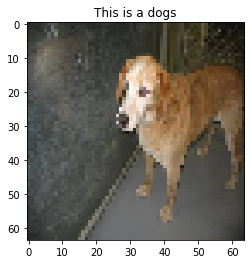

In [10]:
##Try plotting data from numpy array to make sure that reshaping is correct##
classes = {0: 'cats',
           1: 'dogs'}

def show_images(X, y, idx) :
  image = X[:,idx]
  image = image.reshape((IMG_HEIGHT, IMG_WIDTH, 3))
  plt.figure(figsize=(4,4))
  plt.imshow(image)
  plt.title("This is a {}".format(classes[y[idx]]))
  plt.show()

show_images(X_train, y_train, 1)

***Model1: Logistic regression***

In [12]:
##Perform logistic regression##
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

##Data##
X_train_lr, y_train_lr = X_train.T, y_train.T.ravel()
X_val_lr, y_val_lr = X_val.T, y_val.T.ravel()

##Model##
clf = LogisticRegression(verbose = False, max_iter=1000)
clf.fit(X_train_lr, y_train_lr)

##Performance##
test_pred = clf.predict(X_val.T)
accuracy_score(y_val.T, test_pred)

0.551

***Model2: Linear regression***

0.551


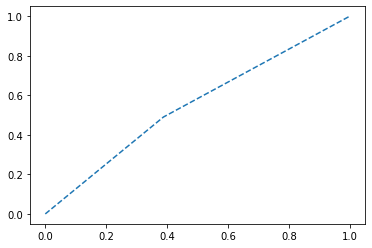

In [14]:
##Perform linear regression##
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

##Data##
X_train_lr, y_train_lr = X_train.T, y_train.T.ravel()
X_val_lr, y_val_lr = X_val.T, y_val.T.ravel()

##Model##
clf = LinearRegression()
clf.fit(X_train_lr, y_train_lr)

##Performance##
#AUC##
auc = roc_auc_score(y_val_lr, test_pred)
print(auc)

##AUC curve##
fpr, tpr, _ = roc_curve(y_val_lr, test_pred)
plt.plot(fpr, tpr, linestyle='--')

***Model3.1: SVM without hyper-parameter tuning***

In [16]:
##Perform SVM WITHOUT tuning##
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

##Data
X_train_lr, y_train_lr = X_train.T, y_train.T.ravel()
X_val_lr, y_val_lr = X_val.T, y_val.T.ravel()

##Model with no hyper-parameter tuning##
clf = SVC()
clf.fit(X_train_lr, y_train_lr)

##Performance##
test_pred = clf.predict(X_val_lr)
accuracy_score(y_val_lr, test_pred)

0.614

***Model3.2: SVM with hyper-parameter tuning***

In [19]:
##Perform SVM WITH tuning##
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#Defining parameter range##
param_grid = {'C': [0.1, 10],  
              'gamma': [1, 0.01], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
##Data##
X_train_lr, y_train_lr = X_train.T, y_train.T.ravel()
X_val_lr, y_val_lr = X_val.T, y_val.T.ravel()

#Model with grid of hyper-parameters##
grid.fit(X_train_lr, y_train_lr)

##Performance##
test_pred = grid.predict(X_val_lr)
accuracy_score(y_val_lr, test_pred) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=  56.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.520, total=  56.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.515, total=  56.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=  55.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=  55.6s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.492, total=  55.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.505, total=  55.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.527, total=  54.9s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.497, total=  55.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 18.7min finished


0.552

It should be noted that the poor performance of SVM WITH tuning (worse than WITHOUT tuning) is due to a very small grid.